# Wright-Fisher Simulations

*in progress*

## Imports / configuration


In [ ]:
#%load_ext autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pb
import gpflow

#%autoreload 2

# import helper functions
import sys
sys.path.append("./src")
import simulator as sim
import likopt 
import gpext

# configure plot style
sns.set_context("poster")
sns.set_style("whitegrid", 
              {"axes.facecolor": "1.0", 
               "axes.edgecolor": "0.5",
               "grid.linestyle": "-",
              })
plt.style.use("whitegrid.mplstyle")

## Simulation

Simulate allele frequencies at mutation drift equlibrium

In [2]:
p = 100000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 350 # number of generations to sim 700*25 17500
u = 1. / (4. * n_e) # A->a mutation 
v = 1. / (4. * n_e) # a->A mutation

#F = sim.simulate_frequencies(p, n_e, max_gen, u, v, f=None)
F_home = sim.simulate_frequencies(p, n_e, max_gen, u, v)
F_away = sim.simulate_frequencies(p, n_e, max_gen, u, v)
m = 0.1
f = (m * F_away[-1, :]) + ((1.-m) * F_home[-1, :])

Q = sim.simulate_frequencies(p, n_e, max_gen, u, v, f=f)
F = np.vstack([F_home, Q])

Simulate genotypes

In [4]:
n = 20 # number of sampled individuals

# sampled time points
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = sim.simulate_genotypes(t, F)

Simulate reads

In [12]:
eps = .01 # error rate
lamb = .005 # average coverage
Y, C = sim.simulate_reads(X, eps, lamb)

Plot a hist of the coverage distribution for a the first individual

507


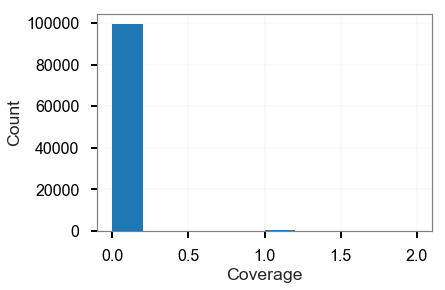

In [13]:
i = 5
plt.hist(C[i,:]);
print(np.sum(C[i,:] > 0))
plt.xlabel("Coverage");
plt.ylabel("Count");

Plot some example trajectories

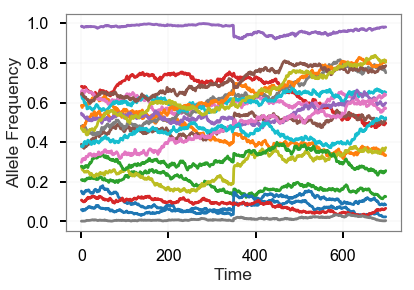

In [14]:
idx = np.sort(np.random.choice(range(p), size=20, replace=False))
for j in idx:
    plt.plot(range(2 * max_gen), F[:,j])
    
plt.xlabel("Time");
plt.ylabel("Allele Frequency");

Compute the population heterozygosity

In [15]:
H = 2 * F * (1 - F) # for all time points
h_true = np.sum(H, axis=1) / p
h = h_true[t] # for sampled time points

Compute an estimate of heterozygosity from the read data

In [16]:
%%time

h_hat = np.empty(n)
sigma2 = np.empty(n)

for i in range(n):
    L = likopt.comp_lik_mat(Y[i,:], C[i,:], eps, n_samp=0)
    pi_hat = likopt.est_freq_read(L)
    h_hat[i] = pi_hat[1]
    sigma2[i] = likopt.comp_lik_var(L, pi_hat)
    if i % 5 == 0:
        print(i)

0
5
10
15
CPU times: user 1min 55s, sys: 2.18 s, total: 1min 57s
Wall time: 1min 57s


This runs pretty fast for each individual and we only have to compute it once. Plot population heterozygosity against time

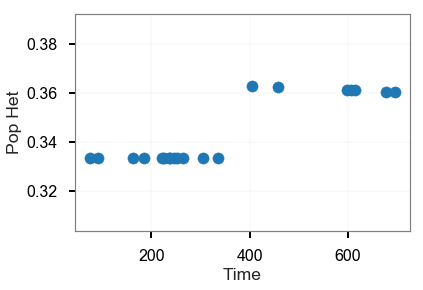

In [17]:
plt.scatter(t, h)
plt.xlabel("Time");
plt.ylabel("Pop Het");

Plot estimated heterozygosity against time

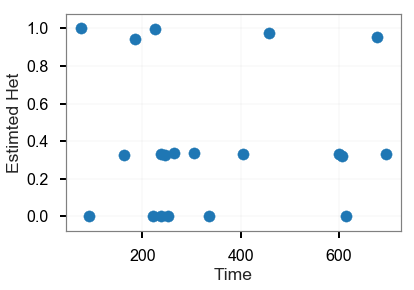

In [18]:
plt.scatter(t, h_hat)
plt.xlabel("Time");
plt.ylabel("Estimted Het");

## Inference

Fit a Gaussian Process regression model with a Matern kernal. We use an emprical Bayes approach where the marginal likelihood is maximized to estimate hyper parameters of the covariance kernal and then posterior is then analytically computed ...

In [90]:
import tensorflow as tf
class ExpNonSep(gpflow.kernels.Stationary):
    """
    A non-separable exponential kernel
    """
    @gpflow.decors.params_as_tensors
    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
           
        r2_0 = self.scaled_square_dist(X=X, X2=X2)
        r = tf.sqrt(r2_0 + 1e-12)

        return self.variance * tf.exp(-.5 * r)

In [96]:
#model = gpext.GPRHet(t[:,None].astype(np.float64), h_hat[:,None], kern=gpflow.kernels.Matern32(1))
model = gpext.GPRHet(np.vstack([t.astype(np.float64), t.astype(np.float64)]).
                               h_hat[:,None], 
                                kern=gpflow.kernels.Matern32(2),
                               active_dims=[0, 0])
model.s2_hat = sigma2
model.s2_hat.trainable = False

model.likelihood.variance = 0.0
model.likelihood.variance.trainable = False

AttributeError: 'numpy.ndarray' object has no attribute 'h_hat'

In [92]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -55.514448
  Number of iterations: 37
  Number of functions evaluations: 47


In [93]:
xx = np.array(list(range(2*max_gen))).reshape(2*max_gen, 1)
mu, var = model.predict_y(xx)

# double check i think its returning variance in exp scale
#var = var

<tf.Variable 'GPRHet-81a6a278-315/X/dataholder:0' shape=<unknown> dtype=float64_ref>
<tf.Variable 'GPRHet-81a6a278-315/X/dataholder:0' shape=<unknown> dtype=float64_ref>


Fitting this is incredibly quick!

## Critique


Here is a plot of the posterior mean and variance output by the analytical posterior of the Gaussian Process model

Text(0,0.5,'Exp Het')

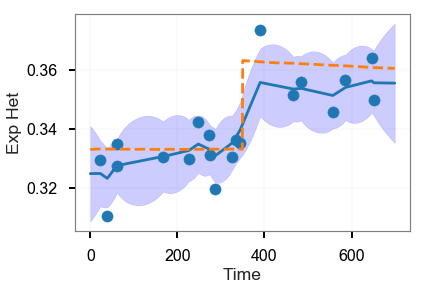

In [18]:
plt.plot(mu)
plt.fill_between(xx[:,0], mu[:,0] -  2 * np.sqrt(var[:,0]), 
                 mu[:,0] + 2 * np.sqrt(var[:,0]), 
                 color="blue", 
                 alpha=0.2)
plt.plot(xx, h_true, linestyle="--")
plt.scatter(t, h_hat)
plt.xlabel("Time");
plt.ylabel("Exp Het")

In [ ]:
#model.plot_f([0, max_gen]);
#plt.xlabel("Time");
#plt.ylabel("Posterior Mean");
#plt.plot(t, h_hat,'kx', mew=1.5);

In [ ]:
sim.plot_xy(mu[t,0], h)
plt.xlabel("Posterior Mean");
plt.ylabel("Pop Het");
print(np.corrcoef(mu[t,0], h)[0, 1])

In [ ]:
sim.plot_xy(h_hat, h)
plt.xlabel("MLE")
plt.ylabel("Pop Het")
np.corrcoef(h_hat, h)[0,1]